# Import Necessary Packages

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout


In [20]:
data = pd.read_csv('./creditcard.csv')

In [21]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Exploring Data

In [22]:
data["Class"].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [23]:
X = data.drop(['Class', 'Time'], axis = 1)
y = data["Class"]

In [24]:
X_train, X_test,y_train,y_test = train_test_split(X,y, shuffle=True, test_size=0.3,random_state=42 )

# Defining Model

In [25]:
class Autoencoder(Model):
    def __init__(self):
        super().__init__()
        
        self.encoder = Sequential([
            Dense(64, activation='relu'),
            Dropout(0.2),
            Dense(32, activation='relu'),
        ])
        
        self.code = Sequential([
            Dense(16,activation='relu')
        ])
        
        self.decoder = Sequential([
            Dense(32,activation='relu'),
            Dropout(0.2),
            Dense(64,activation='relu'),
            Dropout(0.2),
            Dense(29,activation='relu')
        ])
        
    def call(self, inputs, *args):
        encoded_inputs = self.encoder(inputs)
        code = self.code(encoded_inputs)
        decoded_inputs = self.decoder(code)
        return decoded_inputs

# Training the model

In [26]:
model = Autoencoder()
model.compile(loss='mse', optimizer='adam')

In [27]:

history = model.fit(X_train, X_train, epochs=10, validation_data=(X_test, X_test))

Epoch 1/10
6231/6231 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - loss: 86.6098 - val_loss: 1.1424
Epoch 2/10
6231/6231 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 6.1522 - val_loss: 17.1070
Epoch 3/10
6231/6231 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - loss: 5.6731 - val_loss: 0.9291
Epoch 4/10
6231/6231 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 8.1104 - val_loss: 1.3712
Epoch 5/10
6231/6231 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - loss: 2.6479 - val_loss: 1.1584
Epoch 6/10
6231/6231 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 2.7517 - val_loss: 1.1020
Epoch 7/10
6231/6231 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 2.1400 - val_loss: 1.0483
Epoch 8/10
6231/6231 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 3.8326 - val_loss: 0.9835
Epoch 9/10
6231/6231 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 3.9055 - val_loss: 0.9733
Epoch 10/10
6231/6231 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - loss: 1.7288 - val_loss: 0.9607


In [28]:
# Calculate reconstruction error for training data and set the threshold
reconstructed_train = model.predict(X_train)
train_mse = np.mean(np.square(X_train - reconstructed_train), axis=1)
threshold = np.mean(train_mse) + np.std(train_mse)
print(f"Threshold for anomaly detection: {threshold}")

6231/6231 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step
Threshold for anomaly detection: 6.052749137162838


In [29]:
# Predict and calculate MSE for test data
reconstructed_test = model.predict(X_test)
test_mse = np.mean(np.square(X_test - reconstructed_test), axis=1)

2671/2671 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


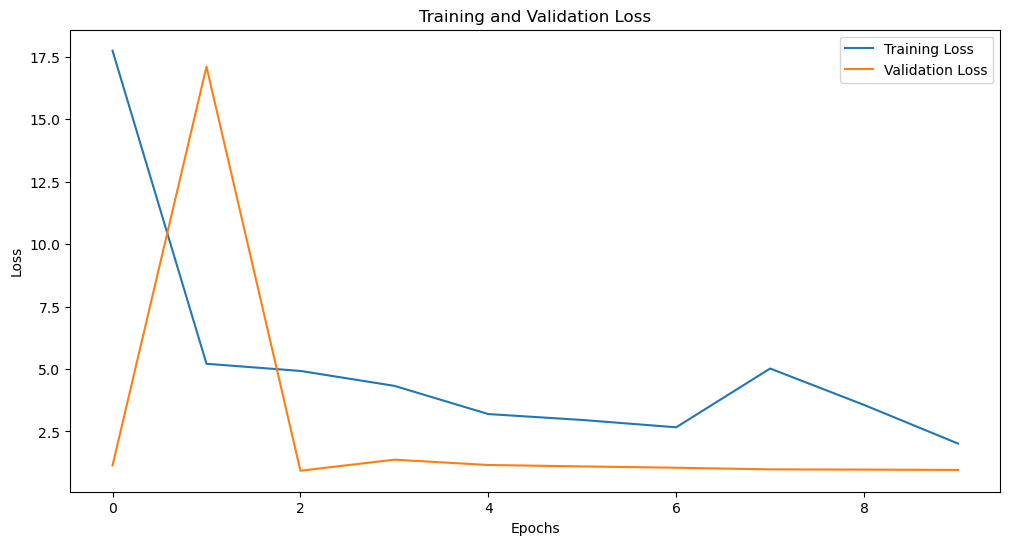

In [33]:
# Visualize training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

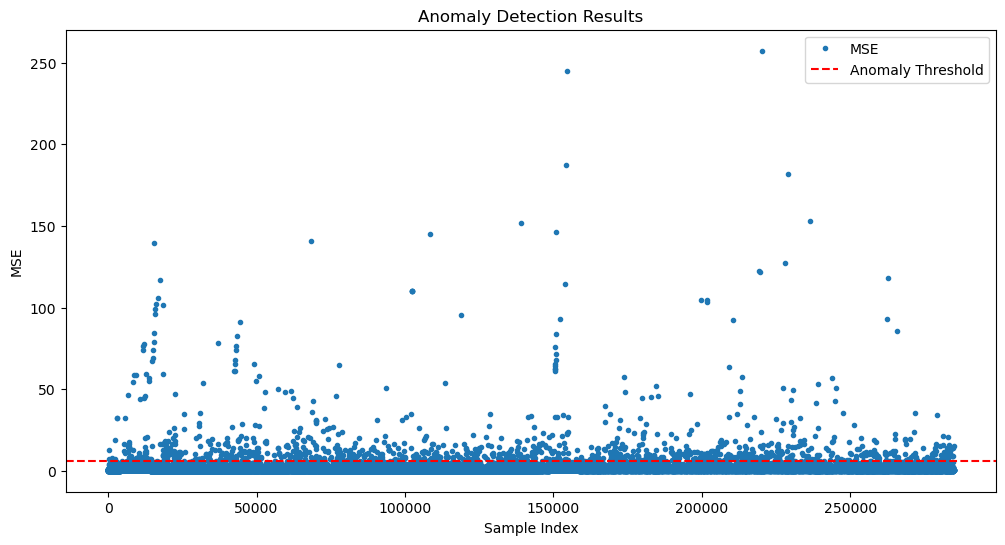

In [34]:
# Plot the MSE distribution and threshold
plt.figure(figsize=(12, 6))
plt.plot(test_mse, marker='o', linestyle='', markersize=3, label='MSE')
plt.axhline(threshold, color='r', linestyle='--', label='Anomaly Threshold')
plt.xlabel("Sample Index")
plt.ylabel("MSE")
plt.title("Anomaly Detection Results")
plt.legend()
plt.show()

In [35]:
# Compare sample normal and anomalous credit card transactions
normal_sample = X_test.iloc[0]
anomalous_sample = X_test.iloc[1]  # Use an actual anomalous sample if possible

In [36]:
normal_reconstructed = model.predict(normal_sample.values.reshape(1, -1))[0]
anomalous_reconstructed = model.predict(anomalous_sample.values.reshape(1, -1))[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


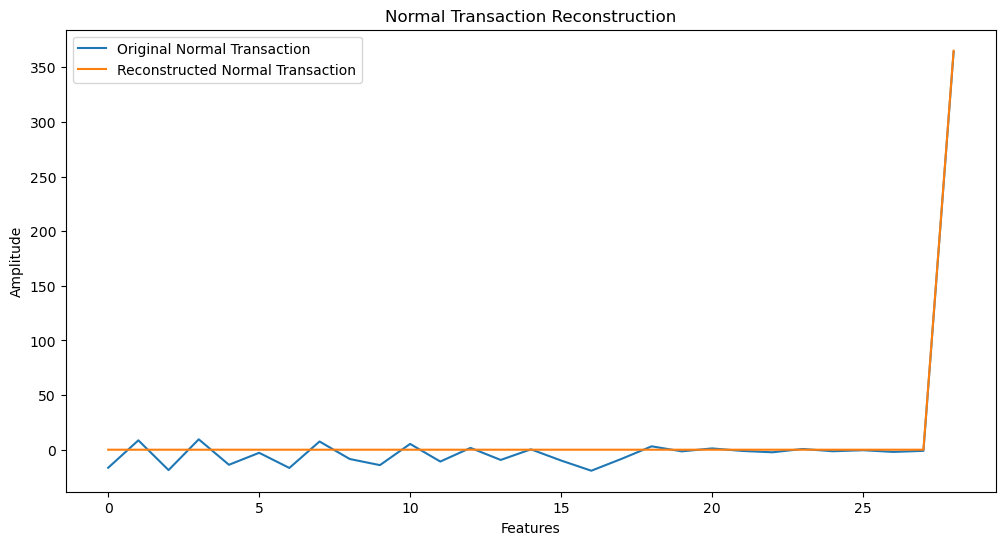

In [17]:
# Visualize a sample of normal vs. anomalous transaction reconstruction
plt.figure(figsize=(12, 6))
plt.plot(normal_sample.values, label='Original Normal Transaction')
plt.plot(normal_reconstructed, label='Reconstructed Normal Transaction')
plt.xlabel("Features")
plt.ylabel("Amplitude")
plt.legend()
plt.title("Normal Transaction Reconstruction")
plt.show()


In [18]:
# Making predictions and calculating accuracy
preds = (test_mse > threshold).astype(int)
print("Classification Report:\n", classification_report(y_test, preds))
print("Accuracy Score:", accuracy_score(y_test, preds))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     85307
           1       0.08      0.65      0.14       136

    accuracy                           0.99     85443
   macro avg       0.54      0.82      0.57     85443
weighted avg       1.00      0.99      0.99     85443

Accuracy Score: 0.9871376239130181
